# MonthlySVD
This code shows as simple way to:
- Read in a .nc file using xarray
- Generate montly anomalies from climatology of monthly means
- detrend data by grid cell
- calculate singular value decomposition by grid cell, dim = month * year


In [1]:
import xarray as xr
import cf_units as cf
import numpy as np
import pandas as pd
import esmlab
from ctsm_py import utils
import segment as sg
import scipy                    # Try scipy to detrend
from scipy import signal

# some resources for plotting
import matplotlib.pyplot as plt
#import cartopy
#import cartopy.crs as ccrs
%matplotlib inline

In [2]:
import warnings

# supress Runtime warnings that let you know when code isn't too efficiently
warnings.simplefilter("ignore", category=RuntimeWarning)

# TODO, turn warmings back on with code below? 
#warnings.resetwarnings()

## ---- Read in data ----

In [3]:
variables = ['GPP','TBOT','TWS']

# --- CLM5 w/ GSWP3 ---
model = 'CLM5_GSWP3'
pattern = '/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist/'\
    'lnd/proc/tseries/month_1/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.{var}.185001-201412.nc'

# --- CLM45 w/ GSWP3 ---
#model ='CLM45_GSWP3'
#pattern = '/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM4.5/clm45_r270_1deg_GSWP3V1_hist/'\
#    'lnd/proc/tseries/month_1/clm45_r270_1deg_GSWP3V1_hist.clm2.h0.{var}.185001-201412.nc'

# --- Danica's no crop run ---
#model = 'CLM5_GSWP3_noCrop'
#pattern = '/glade/p/cesm/lmwg_dev/dll/CLM5GSWP3_NoCrop/SingleVarTimeFiles/'\
#    'clm50_r267_1deg_GSWP3V1_iso_hist_nocrop_transientfix.clm2.h0.{var}.185001-201012.nc'

file = [pattern.format(var=var) for var in variables]
print(file[1])
# would be nice to just do this in a loop...
ds0 = utils.time_set_mid(xr.open_dataset(file[0], decode_times=True), 'time')
ds1 = utils.time_set_mid(xr.open_dataset(file[1], decode_times=True), 'time')
ds2 = utils.time_set_mid(xr.open_dataset(file[2], decode_times=True), 'time')
ds  = xr.merge([ds0, ds1, ds2])
ds['TBOT'] = ds.TBOT - 273.15

#redundant, but we'll keep using this for now because 'var' is used more later on...
var = variables   
area = ds.area
landfrac = ds.landfrac

/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist/lnd/proc/tseries/month_1/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.TBOT.185001-201412.nc


In [4]:
# JH suggestions, trouble shooting to see if this is why loop below fails...
# reading data this way gets rid of chunk sizes

# utils.time_set_mid corrects dates, to get Jan of first year
# combine needed for newer xarray versions
# ds = utils.time_set_mid(xr.open_mfdataset(files, combine='by_coords', decode_times=True), 'time') 

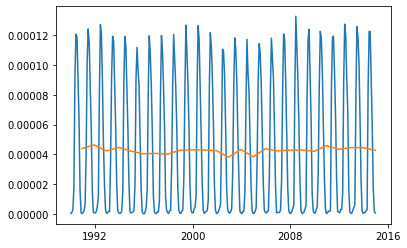

In [51]:
years = 25
months = years * 12
tlat = 60#-5 #  #46  #-3
tlon = 240#300 #262 #280
ds_test = ds.sel(lat=tlat, lon=tlon, method='nearest') #select a single grid point to work with first
ds_last = ds_test.isel(time=slice(-months,None))
dataset = ds_last.get(var)
ds_ann  = dataset.apply(utils.weighted_annual_mean)
plt.plot(ds_last.time['time'], ds_last.get(var[0]), '-' )
plt.plot(ds_ann.time['time'], ds_ann.get(var[0]), '-' );

### Calculate climatology and anomalies

In [52]:
# esmlab anomaly function needs time_bounds in the dataset!
# test to see of climatology and anomaly functions see to work appropriately?
# resample monthly data to seasonal
ds_clim = esmlab.core.climatology(ds_last,freq='mon', time_coord_name='time')
ds_anom = esmlab.core.anomaly(ds_last, clim_freq='mon', time_coord_name='time')
ds_detrend = ds_anom.get(var).map(signal.detrend)   # still need to use get so detrend works
ds_detrend_season = ds_detrend.resample(time="QS-DEC").mean()

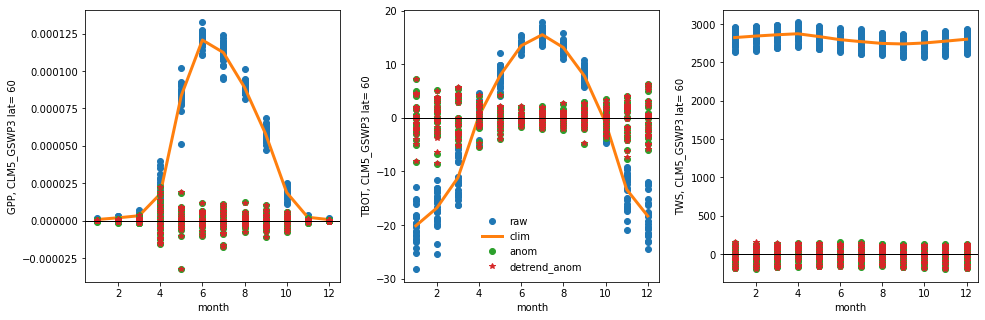

In [53]:
# now look at seasonal
plt.figure(figsize=[16,5])
for i in range(3):
    plt.subplot(1, 3, (1+i))
    plt.plot(ds_last.time['time.month'], ds_last.get(var[i]), 'o' )
    plt.plot(ds_clim.time['time.month'], ds_clim.get(var[i]), '-', lw=3 )
    plt.plot(ds_anom.time['time.month'], ds_anom.get(var[i]), 'o' )
    plt.plot(ds_anom.time['time.month'], ds_detrend.get(var[i]), '*' )
    plt.axhline(0, color='black', lw=1);
    plt.ylabel(var[i]+", "+model+" lat= "+str(tlat))
    plt.xlabel('month')
    if i == 1:
        plt.legend(labels=('raw','clim','anom','detrend_anom'),frameon = False)
plt.subplots_adjust(wspace=0.25)

#### Seaonal GPP anomalies seem to show a similar pattern to TWS in CLM4.5 
#### Stonger temperature sensitivity w/ CLM5?

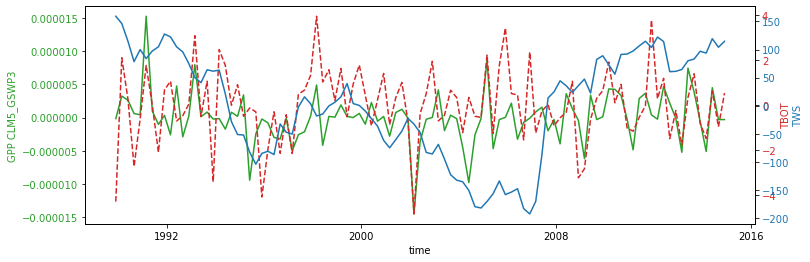

In [54]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,1,1)

color = 'tab:green'
ax1.set_xlabel('time')
ax1.set_ylabel(var[0]+" "+model, color=color)
ax1.plot(ds_detrend_season.time, ds_detrend_season.get(var[0]), '-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel(var[1], color=color)  # we already handled the x-label with ax1
ax2.plot(ds_detrend_season.time, ds_detrend_season.get(var[1]), '--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax3.set_ylabel(var[2], color=color)  # we already handled the x-label with ax1
ax3.plot(ds_detrend_season.time, ds_detrend_season.get(var[2]), '-', color=color)
ax3.tick_params(axis='y', labelcolor=color)
plt.show();

 ### Do we need to detrend data?

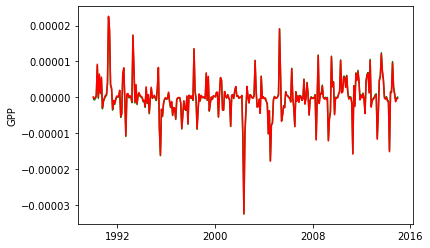

In [55]:
plt.plot(ds_anom.time['time'], ds_anom.get(var[0]), '-',c='green' )
plt.plot(ds_anom.time['time'], ds_detrend.get(var[0]), '-' ,c='red')
plt.ylabel(var[0]);

### Start singular vector decomposition
#### This is from Gretchen's CLM_SVD code 

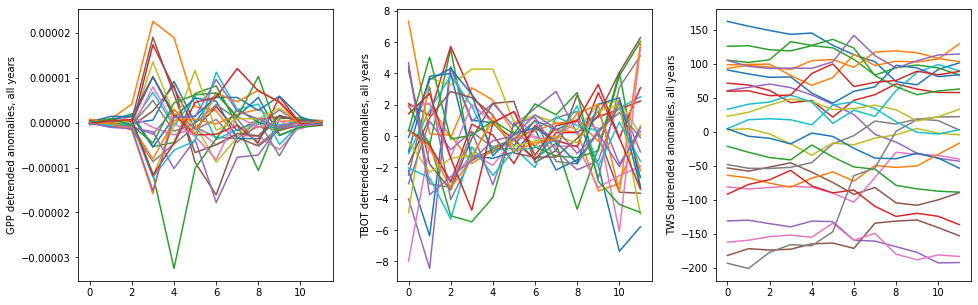

In [56]:
# orig. mon x year
iavmatrix =np.zeros([3, 12, years])
for i in range(len(var)):
    for iyr in range(years):
        iavmatrix[i, 0:12, iyr]=ds_detrend.get(var[i])[iyr*12:(iyr+1)*12] #reshape timeseries vector into a matrix (year x month) 

plt.figure(figsize=[16,5])
for i in range(3):
    plt.subplot(1, 3, (1+i))
    plt.ylabel(var[i]+' detrended anomalies, all years')
    plt.plot(iavmatrix[i,:,:]);
    
plt.subplots_adjust(wspace=0.25)

### Now try using SVD_tools.py
This code was provided by Gretchen Keppel-Aleks & initially developed by Zach Butterfield

Further modified by W. Wieder to accept matrix when years > 12 (nmonths)
- Decompose function accepts a month * year matrix and calculates vectors (dimensions = years,months) and weights (years,years)  
- Redistribution function takes vectors, weights, and matrix to calculate theta (years), & varfrac (years)

In [57]:
import SVD_tools as svd

#assign the 2-D matrix (month x year) to decompose
#Call the function to calculate the singular vectors and their annual weights
vectors, weights=svd.decompose(iavmatrix[0,:,:]) 
theta ,varfrac =svd.calc_redistribution(vectors , weights , iavmatrix[0,:,:])
print(vectors.shape)  #(nyears , nmonths)
print(weights.shape)
#print(ds_detrend_season) #(101 time slices, needs to be reshaped to nyears*season)

# ----- run all stats on hydrologic year in SH ----- 
mm2plot=ds_clim.get(var[0])
idx = [6,7,8,9,10,11,0,1,2,3,4,5]

if tlat < 0:
    mm2plot = mm2plot[idx]
    for i in range(2): # just focus on first two vectors
        vectors[i,:] = vectors[i,:][idx]

(25, 12)
(25, 25)


In [58]:
# also try spearman's rank correlation
from scipy.stats import spearmanr
    
corr0, _ = spearmanr(mm2plot,vectors[0,:])
corr1, _ = spearmanr(mm2plot,vectors[1,:])
print('Spearmans correlation SV1 vectors ~ Climatology: %.3f' % corr0)
print('Spearmans correlation SV2 vectors ~ Climatology: %.3f' % corr1)

# also try weighting correlation based on monthly contribution to annual flux
wgt = mm2plot/mm2plot.sum()
def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - np.average(x, weights=w)) * (y - np.average(y, weights=w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

r = np.zeros(years)
for i in range(years):
    r[i] = corr(mm2plot.values,vectors[i,:], wgt.values)
    
print('weighted correlation SV1 vectors ~ Climatology: %.3f' % r[0])
print('weighted correlation SV2 vectors ~ Climatology: %.3f' % r[1])
## for our generic tropical plot, SV1 = early shift & SV2 = amplification

Spearmans correlation SV1 vectors ~ Climatology: 0.399
Spearmans correlation SV2 vectors ~ Climatology: -0.804
weighted correlation SV1 vectors ~ Climatology: 0.401
weighted correlation SV2 vectors ~ Climatology: -0.571


#### Can correlations between climatology and Vectors tell us someting about the nature of relationships?
#### In this example SV? shows higher correlation with climatology of GPP

In [59]:
## add logicals to flip vectors and weights if:
# 1a) amplificaiton vector and correlation with climatology < 0
# 2) phase shift vector and minVector comes before maxVector
# 1b) amplificaiton vector and sum(vectors)<0 [this corrects issues in the tropics]

flip_corr = r<0

min_vector = np.argmin(vectors, axis=1)
max_vector = np.argmax(vectors, axis=1)
flip_vector = min_vector < max_vector

# only flip corr where amplificaiton, vector where phase
if np.absolute(r[0])<np.absolute(r[1]):
    flip_corr[0] = False
    flip_vector[1] = False
else:
    flip_corr[1] = False
    flip_vector[0] = False

flip_vector = flip_corr + flip_vector
print(flip_vector)

for i in range(years):
    if flip_vector[i] == True:
        vectors[i,:] = -vectors[i,:]
        weights[i,:] = -weights[i,:]

[ True  True False False  True  True  True  True False False False  True
 False False False False False False False False False False False False
 False]


In [60]:
flip_amp =  np.mean(vectors, axis=1) < 0.
if np.absolute(r[0])<np.absolute(r[1]):
    flip_amp[0] = False

for i in range(years):
    if flip_amp[i] == True:
        vectors[i,:] = -vectors[i,:]
        weights[i,:] = -weights[i,:]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


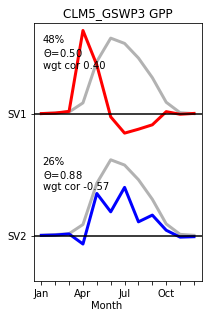

In [61]:
# Plot First and Second Singular Vectors
# TODO This is a pretty complicated plotting method that could likely be improved & made into a function
# That said, the it makes nice, clear plots... we'll keep it for now

fig = plt.figure(4,figsize=(3,4.5))
ax1 = fig.add_subplot(111)
month = np.arange(12)
barwidth = 0.2
ymax=np.max(vectors)
vectors2plot=vectors*7000  #This is a totally arbitrary scale factor, 
#                            decided by me, to make figures look good!
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))-0.05,'k-',alpha=0.3,linewidth=3)
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))+0.35,'k-',alpha=0.3,linewidth=3)
ax1.plot(np.array(month)+2*barwidth,vectors2plot[0,:]*0.75+0.35,'r-',linewidth=3)
ax1.plot(np.array(month)+2*barwidth,vectors2plot[1,:]*0.75-0.05,'b-',linewidth=3)
ax1.axhline(-0.05,color='black')
ax1.axhline(0.35,color='black')
ax1.set_xticks(np.array(month)+2*barwidth)
ax1.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
ax1.set_yticks([-0.05,0.35])
ax1.set_yticklabels(['SV2','SV1'])
ax1.set_ylim([-0.2,0.65])
ax1.text(0.5,.50,str(int(varfrac[0]*100))+"%\n$\Theta$="+str('%.2f'%theta[0])+
        "\n"+str('wgt cor %.2f' % r[0]))
ax1.text(0.5,.10,str(int(varfrac[1]*100))+"%\n$\Theta$="+str('%.2f'%theta[1])+
        "\n"+str('wgt cor %.2f' % r[1]))

ax1.title.set_text(model +' '+var[0])
ax1.text(4,-0.29,'Month')
plt.tight_layout()
plt.savefig('SVD_'+model+'_ex_GPP.eps') ;


### How do weights from SV correlate with seasonal climate anomalies?

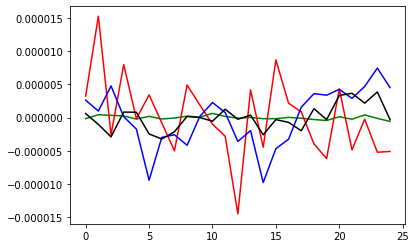

In [62]:
# TODO, there must be a better way to reshape data, but I can't get group by to work
season_group = ds_detrend_season.groupby('time.month')

#reshape timeseries vector into a matrix (season x year)
# Omits the last year, which only has data for Dec
group_0 =np.zeros([4, years])
group_1 =np.zeros([4, years])
group_2 =np.zeros([4, years])

# Reshape timeseries vector into a matrix (season x year) 
# this could also be done with np.reshape...
for iyr in range(years):
    group_0[0:4,iyr]=ds_detrend_season.get(var[0])[(iyr*4):(iyr*4)+4] 
    group_1[0:4,iyr]=ds_detrend_season.get(var[1])[(iyr*4):(iyr*4)+4] 
    group_2[0:4,iyr]=ds_detrend_season.get(var[2])[(iyr*4):(iyr*4)+4] 

# Plot seasonal anomalies by year
plt.plot(group_0[0,], '-',color='green')#DJF
plt.plot(group_0[1,], '-',color='red' ) #MAM
plt.plot(group_0[2,], '-',color='blue' )  #JJA
plt.plot(group_0[3,], '-',color='black' ); #SON

In [63]:
# --- Correlations with climate anomalies ---
print('correlation of sv weights & with seasonal anomalies')
quarter = (['DJF','MAM','JJA','SON']) # can coords be a string?

# Here using weights that were flipped like the vectors
for h in range(2):# vectors
    print("  -------- SV"+str(h+1)+" -----------")
    for i in range(4):# season
        r0 = corr(weights[h,:],group_0[i,:],np.ones(years))
        r1 = corr(weights[h,:],group_1[i,:],np.ones(years))
        r2 = corr(weights[h,:],group_2[i,:],np.ones(years))
        print('GPP weights SV ~ GPP '+quarter[i]+' anom. : %.3f' % r0)
        print('GPP weights SV ~ TBOT '+quarter[i]+' anom. : %.3f' % r1)
        print('GPP weights SV ~ TWS '+quarter[i]+' anom. : %.3f' % r2)
        print('--')
    
# once we arrange the vectors correctly
# phase shift (SV1),  + correlated with MAM TBOT anomalies, - correlated with SON TWS
# amplification(SV2), + correlated with JJA TWS anomalies
# this pattern of Phase ~ TBOT & Amp ~ TWS holds for CLM4.5 too

correlation of sv weights & with seasonal anomalies
  -------- SV1 -----------
GPP weights SV ~ GPP DJF anom. : 0.434
GPP weights SV ~ TBOT DJF anom. : 0.196
GPP weights SV ~ TWS DJF anom. : -0.192
--
GPP weights SV ~ GPP MAM anom. : 0.965
GPP weights SV ~ TBOT MAM anom. : 0.746
GPP weights SV ~ TWS MAM anom. : -0.230
--
GPP weights SV ~ GPP JJA anom. : -0.359
GPP weights SV ~ TBOT JJA anom. : -0.056
GPP weights SV ~ TWS JJA anom. : -0.245
--
GPP weights SV ~ GPP SON anom. : -0.180
GPP weights SV ~ TBOT SON anom. : -0.061
GPP weights SV ~ TWS SON anom. : -0.208
--
  -------- SV2 -----------
GPP weights SV ~ GPP DJF anom. : 0.081
GPP weights SV ~ TBOT DJF anom. : -0.096
GPP weights SV ~ TWS DJF anom. : 0.671
--
GPP weights SV ~ GPP MAM anom. : 0.256
GPP weights SV ~ TBOT MAM anom. : 0.302
GPP weights SV ~ TWS MAM anom. : 0.703
--
GPP weights SV ~ GPP JJA anom. : 0.846
GPP weights SV ~ TBOT JJA anom. : 0.080
GPP weights SV ~ TWS JJA anom. : 0.770
--
GPP weights SV ~ GPP SON anom. : 0.545

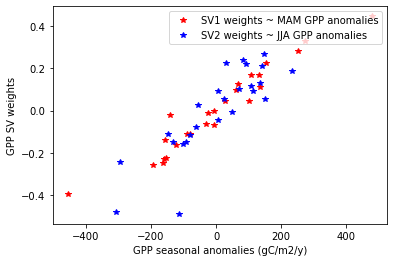

In [64]:
# in the NH gridcell, 
# weights for SV1 of GPP = the inverse as MAM GPP anomalies 
# weights for SV2 of GPP = the inverse as JJA GPP anomalies
# in SH
# SV1 weights - corr w/ GPP & TWS in JJA and SON
# SV2 weights + corr w/ GPP in MAM, not climate 

s2y = 3600 * 24 * 365
if tlat>=0:
    plt.plot(group_0[1,:]*s2y,(weights[0,:]), '*', color='red' )
    plt.plot(group_0[2,:]*s2y,(weights[1,:]), '*', color='blue' )
    plt.legend(loc='upper right',labels=("SV1 weights ~ MAM GPP anomalies",
                                        "SV2 weights ~ JJA GPP anomalies"))
else:
    plt.plot(group_0[3,:]*s2y,(weights[0,:]), '*', color='red' )
    plt.plot(group_0[1,:]*s2y,(weights[1,:]), '*', color='blue' )
    plt.legend(loc='upper right',labels=("SV1 weights ~ SON GPP anomalies",
                                         "SV2 weights ~ MAM GPP anomalies"))

plt.xlabel(var[0]+" seasonal anomalies (gC/m2/y)")
plt.ylabel(var[0]+" SV weights");

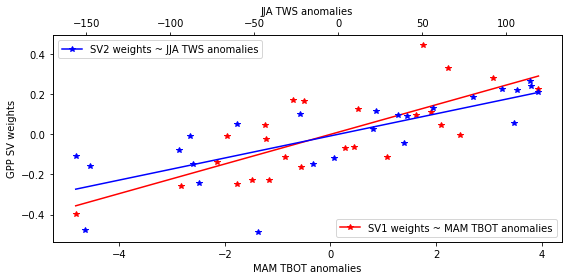

In [65]:
import matplotlib.lines as mlines
# let's reverse weights for clarity (vectors are reversed above)
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(1,1,1)
color = 'red'
if tlat>=0:
    x = group_1[1,:]  #MAM TBOT
    xlab = 'MAM '+var[1]+' anomalies'
else:
    x = group_2[3,:]  #SON TWS
    xlab = 'SON '+var[2]+' anomalies'

y = weights[0,:]  #SV1
ax1.set_ylabel(var[0]+' SV weights')
ax1.set_xlabel(xlab)
ax1.plot(x, y,'*', color=color)
ax1.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color=color)
red_line = mlines.Line2D([], [], color='red', marker='*',label='SV1 weights ~ '+xlab)
ax1.legend(handles=[red_line], loc='lower right')

ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis
color = 'blue'
if tlat>=0:
    x = group_2[2,:]  #JJA TWS
    xlab = 'JJA '+var[2]+' anomalies'
else:
    x = group_2[1,:]  #MAM TWS
    xlab = 'MAM '+var[2]+' anomalies'

y = weights[1,:]  #SV2
ax2.set_xlabel(xlab)
ax2.plot(x, y,'*', color=color)
ax2.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color=color)
ax2.tick_params(axis='x')
blue_line = mlines.Line2D([], [], color='blue', marker='*',label='SV2 weights ~ '+xlab)
ax2.legend(handles=[blue_line], loc='upper left')
fig.tight_layout();

### End of example code  

# ------ Global SVD ------
* Calculate climatology & anomalies, then
* Detrend data & reshape for SVD & finally
* Identify amplification vs. early onset vectors

#### TODO, in the global code we'll need to: 
* Determine how SV weights correspond with GPP anomalies (+ or -)

In [20]:
# Use esmlab to calculate climatology & anomalies
# TODO, refer to variables by name (e.g. anom_gpp) to improve readability
# Will leave this for now to have a more generalizable code
ds2 = ds.isel(time=slice(-months,None))          # Select last N years of data
ds_clim  = esmlab.core.climatology(ds2,freq='mon')    # Calculate climatology
ds_anom  = esmlab.core.anomaly(ds2, clim_freq='mon', time_coord_name='time') #not sure how to use slice_mon_clim_time
ds_anom  = ds_anom.where(ds_anom.get(var[0]).max(dim='time'))  # mask out regions with no GPP for all variables

#### Define wrapper function that includes: 
- Detrending, reshaping, SVD & 
- Returns a np.array with vectors, weights, theta & varfrac
- We dont' need the SV for TBOT and TWS, but we do need seasonal means of detrended anomalies 

In [21]:
# define function to cacluate svd vectors, weights, etc.
# First we have to detrend the data
def svd_wrap(anom, years=years):
    theta = np.full(years, np.nan)
    varfrac = np.full(years, np.nan)
    if np.isnan(anom)[0] == False:
        #detrend results, if needed
        detrend = signal.detrend(anom)  
    
        #reshape timeseries vector into a matrix (months x year) 
        matrix=np.zeros([12, years])
        for iyr in range(years):
            matrix[0:12, iyr]=detrend[iyr*12:(iyr+1)*12] 
    
        #Call the function to calculate the singular vectors and their annual weights
        [vectors, weights]=svd.decompose(matrix) 
        [theta,varfrac]=svd.calc_redistribution(vectors, weights, matrix)

    return theta, varfrac, vectors, weights

In [22]:
## Select a single grid point to work with first
## Make sure wrapper results are the same as above
#[theta_wrap, varfrac_wrap, vectors_wrap, weights_wrap] = svd_wrap(ds_temp.get(var[0]).values, years)
#plt.plot(theta_wrap - theta, '*') ;
#plt.plot(varfrac_wrap - varfrac, '*',c='r') ;
#print ('differences between results look prety small')

#### Make frunction to Loop through each grid cell & dataset to save output
- Would Dask make this faster?
- how do we also mask non-veg land cells?


In [23]:
# TODO, this is the time consuming bit of the code.
# JH recommends using map_blocks, once it's developed farther
def calc_svd(da, nyears=years):
    dims = dict(zip(da.dims, da.shape))
    yx_shape = (dims['lat'], dims['lon'])
    # setup output variables
    # number of vectors in svd = nyears
    theta_shape = yx_shape + (nyears, )
    vector_shape = yx_shape + (nyears, 12)
    weights_shape = yx_shape + (nyears, nyears)
    out = xr.Dataset( coords={"lat": da.lat, "lon": da.lon, 'sv': range(nyears) } )

    varnames = ['theta', 'varfrac', 'vectors', 'weights']
    out['theta'] = xr.DataArray(np.zeros(theta_shape), dims=('lat', 'lon', 'sv'))
    out['varfrac'] = xr.DataArray(np.zeros(theta_shape), dims=('lat', 'lon', 'sv'))
    out['vectors'] = xr.DataArray(np.zeros(vector_shape), dims=('lat', 'lon', 'sv', 'time'))
    out['weights'] = xr.DataArray(np.zeros(weights_shape), dims=('lat', 'lon', 'sv', 'year'))
    # For clarity, rename dimensions of weights (dim1 = vector#, dim2 = year)
    #                                   vectors (dim1 = vector#, dim2 = month)
    for (i, j), mask in np.ndenumerate(da.isel(time=0).isnull()):
        if not mask:
            return_vals = svd_wrap(da.isel(lat=i, lon=j).data)

            for varname, vals in zip(varnames, return_vals):
                out[varname][i, j, ...] = vals

    return out

In [24]:
%%time
# TODO, again more descriptive names will make the code easier to read, but for now keeping general 
# e.g. svd_gpp = calc_svd(ds_anom['GPP'])
da0 = ds_anom.get(var[0]).transpose('time','lat','lon') 
svd0 = calc_svd(da0)  # GPP 
print('finished svd0, '+var[0])

# JH, When I loaded the data as you suggested in cell #2-3, a bunch of warnings crop up.  
# Reading the data less effiently doesn't generate the errors (as curently implimented), 
# and also seems to make the loop work more efficiently.

finished svd0, GPP
CPU times: user 2min 58s, sys: 66.1 ms, total: 2min 58s
Wall time: 2min 58s


In [25]:
# rearrange output & write out to scratch
def transpose(da_in, var):
    out = da_in
    out['theta']   = out.theta.transpose('sv','lat','lon')
    out['varfrac'] = out.varfrac.transpose('sv','lat','lon')
    out['vectors'] = out.vectors.transpose('sv', 'time','lat','lon') 
    out['weights'] = out.weights.transpose('sv', 'year','lat','lon')
    ds_clim['time'] = out.time  # get time coords to match
    out['climatology'] = ds_clim.get(var)
    out.to_netcdf(path='/glade/scratch/wwieder/svd/'+model+'_svd_'+var+'.nc')  
    return out

#this could also be more specific for readability, using 'GPP' instead of var[0]
svd0 = transpose(svd0, var[0])   

#### Reindex over time for sv vectors & climatology for SH to match hydrologic year

In [26]:
svdSH = svd0.copy(deep=True)
svdSH = svdSH.reindex(time=idx)
svdSH['time'] = svd0.time
svd0['climatology'] = svd0.climatology.where(svd0.lat>=0, svdSH.climatology)
svd0['vectors'] = svd0.vectors.where(svd0.lat>=0, svdSH.vectors)

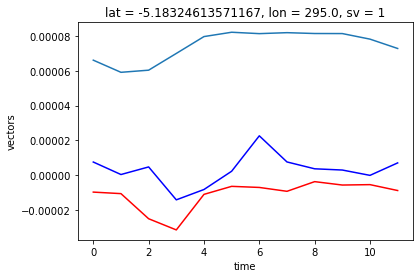

In [27]:
svd0.climatology.sel(lat=-5, lon=295, method='nearest').plot()
svd0.vectors.isel(sv=0).sel(lat=-5, lon=295, method='nearest').plot(color='r')
svd0.vectors.isel(sv=1).sel(lat=-5, lon=295, method='nearest').plot(color='b')

## --- Correlations between vectors and climatology of GPP ---
Example from http://xarray.pydata.org/en/stable/dask.html

In [28]:
import bottleneck
# also try weighting correlation based on monthly contribution to annual flux
# This is code that's likely better suited for a 3rd partly library like esmlab
# TODO, file issue with requst for these kinds of statistical functions to esmlab?

def covariance_gufunc(x, y):
    return ((x - x.mean(axis=-1, keepdims=True))
            * (y - y.mean(axis=-1, keepdims=True))).mean(axis=-1)

def pearson_correlation_gufunc(x, y):
    return covariance_gufunc(x, y) / (x.std(axis=-1) * y.std(axis=-1))

def pearson_correlation(x, y, dim):
    return xr.apply_ufunc(
        pearson_correlation_gufunc, x, y,
        input_core_dims=[[dim], [dim]],
        dask='parallelized',
        output_dtypes=[float])

# Weighted coorelation
def covariance_gufunc_wgt(x, y, w):
    return ((w * x - (x*w).mean(axis=-1, keepdims=True))
            * (y - (y*w).mean(axis=-1, keepdims=True))).mean(axis=-1)

def pearson_correlation_gufunc_wgt(x, y, w):
    return covariance_gufunc_wgt(x, y, w) / np.sqrt(
        covariance_gufunc_wgt(x, x, w) * covariance_gufunc_wgt(y,y,w))

def pearson_correlation_wgt(x, y, w, dim):
    return xr.apply_ufunc(
        pearson_correlation_gufunc_wgt, x, y, w,
        input_core_dims=[[dim], [dim], [dim]],
        dask='parallelized',
        output_dtypes=[float])

# rank correlation
def spearman_correlation_gufunc(x, y):
    x_ranks = bottleneck.rankdata(x, axis=-1)
    y_ranks = bottleneck.rankdata(y, axis=-1)
    return pearson_correlation_gufunc(x_ranks, y_ranks)

def spearman_correlation(x, y, dim):
    return xr.apply_ufunc(
        spearman_correlation_gufunc, x, y,
        input_core_dims=[[dim], [dim]],
        dask='parallelized',
        output_dtypes=[float])

<xarray.DataArray 'time' (time: 12)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 10 11


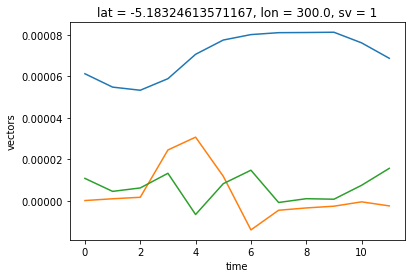

In [29]:
# Pull off climatology of GPP & calculate weights based on annual cycle
print(svd0.time)
GPPwgt  = svd0.climatology / svd0.climatology.sum(dim='time') 
svd0.climatology.sel(lat=tlat, lon=tlon, method='nearest').plot()
svd0.vectors.isel(sv=0).sel(lat=tlat, lon=tlon, method='nearest').plot()
svd0.vectors.isel(sv=1).sel(lat=tlat, lon=tlon, method='nearest').plot()
#GPPwgt.isel(time=0).plot(robust=True); 

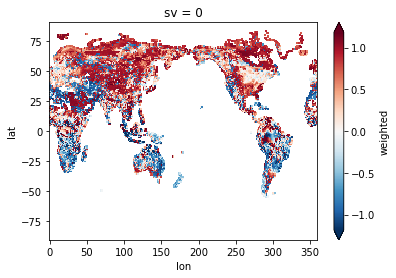

In [30]:
# now calculate the correlations, GPP vectors w/ GPP climatology
# pearson, weighted, and ranked correlations
dims = dict(zip(ds.GPP.dims, ds.GPP.shape))
yx_shape = (dims['lat'], dims['lon'])
# setup output variables

# number of vectors in svd = nyears
corr_shape = (years, ) + yx_shape 
    
GPP_corr = xr.Dataset( coords={'sv': range(years) , "lat": ds.lat, "lon": ds.lon} )
GPP_corr['pearson'] = xr.DataArray(np.zeros(corr_shape), dims=('sv','lat', 'lon'))
GPP_corr['weighted'] = xr.DataArray(np.zeros(corr_shape), dims=('sv','lat', 'lon'))
GPP_corr['ranked'] = xr.DataArray(np.zeros(corr_shape), dims=('sv','lat', 'lon'))

for i in range(years):
    temp_vector = svd0.vectors.isel(sv=i)
    GPP_corr.pearson[i,...] = pearson_correlation(svd0.climatology, temp_vector, 'time')
    GPP_corr.weighted[i,...] = pearson_correlation_wgt(svd0.climatology, temp_vector, GPPwgt,'time')
    GPP_corr.ranked[i,...] = spearman_correlation(svd0.climatology, temp_vector, 'time')

GPP_corr.weighted[0,:,:].plot(robust=True);

### Make plots to visualize results

In [31]:
import matplotlib.colors as colors
import cartopy.feature as cfeature
import cartopy.crs as ccrs

In [32]:
# Generate a function for making panel plots of maps
def map_function(da, cb=0, cmap=None, ax=None, title=None, vmax=None, vmin=None):
    '''a function to make one subplot'''
    if ax is None:
        ax = plt.gca()
    #da.plot(ax=ax)  # more custom args
    im = ax.pcolormesh(da.lon,da.lat,da.values,
                   transform=ccrs.PlateCarree(),
                   vmax=vmax,vmin=vmin,cmap=cmap)
    ax.set_title(title)
    ax.coastlines()
    ax.set_extent([-180,180,-65,80], crs=ccrs.PlateCarree())
    # allows for different colrobars on each plot
    if cb == 1:
        fig.colorbar(im, ax=ax,shrink=0.40, pad=0, fraction = 0.1)

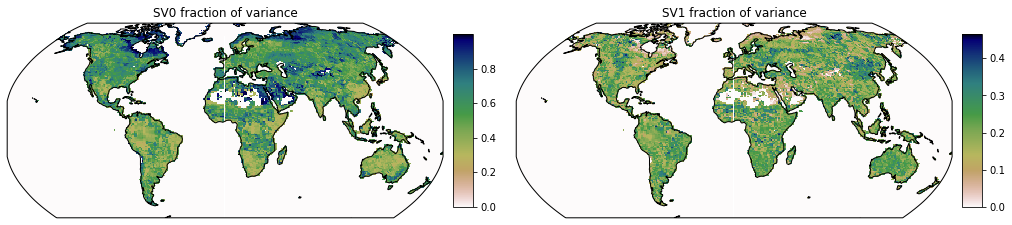

In [33]:
# Now call the map_function
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))

for index, ax in np.ndenumerate(axes):
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    da = svd0.varfrac.isel(sv=index[0])
    map_function(da, ax=ax, title='SV'+str(index[0])+' fraction of variance', 
                  vmax=da.max(), vmin=da.min(), cmap='gist_earth_r',cb=1)

# or to provide a common color bar, set vmax/min so same values and 
#fig.colorbar(im,ax=axes.ravel().tolist(), shrink=0.5);

In [34]:
# Mask values to isolate regions with amplificaiton vs. phase shift (early green-up)?
# here using rank correlation, but also could use weighted 
mask_shape = (2, ) + yx_shape
sv_mask = xr.Dataset( coords={'sv_type': ['amplification','phase shift'] , "lat": ds.lat, "lon": ds.lon} )
sv_mask['ranked'] = xr.DataArray(np.zeros(mask_shape), dims=('sv_type','lat', 'lon'))
sv_mask['ranked'][0,...] = xr.ufuncs.fabs(GPP_corr.ranked[0,...]) >= \
                           xr.ufuncs.fabs(GPP_corr.ranked[1,...])  
sv_mask['ranked'][1,...] = xr.ufuncs.fabs(GPP_corr.ranked[1,...]) > \
                           xr.ufuncs.fabs(GPP_corr.ranked[0,...])  

sv_mask['weighted'] = xr.DataArray(np.zeros(mask_shape), dims=('sv_type','lat', 'lon'))
sv_mask['weighted'][0,...] = xr.ufuncs.fabs(GPP_corr.weighted[0,...]) >= \
                             xr.ufuncs.fabs(GPP_corr.weighted[1,...])  
sv_mask['weighted'][1,...] = xr.ufuncs.fabs(GPP_corr.weighted[1,...]) > \
                             xr.ufuncs.fabs(GPP_corr.weighted[0,...])  


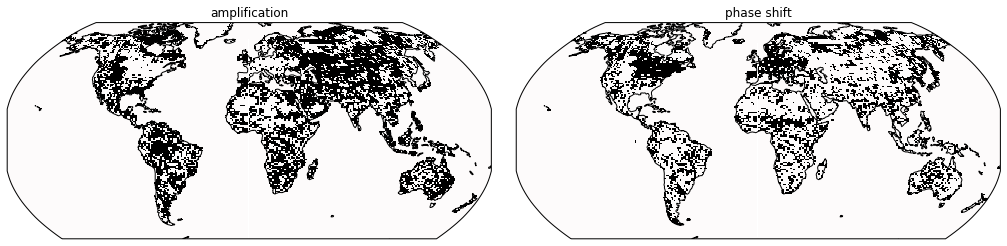

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))

for index, ax in np.ndenumerate(axes):
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    da = sv_mask.weighted.isel(sv_type=index[0])
    map_function(da, ax=ax, title=sv_mask.sv_type[index[0]].values,
                cmap='gist_earth_r')
    

#### Phase shift mainly in agricutrulal regions & temperate decid. forest!

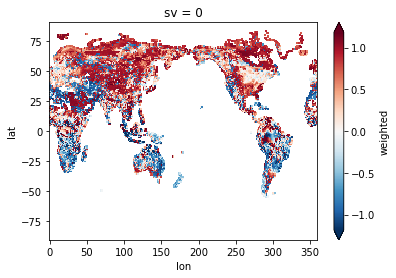

In [36]:
GPP_corr.weighted.isel(sv=0).plot(robust=True);

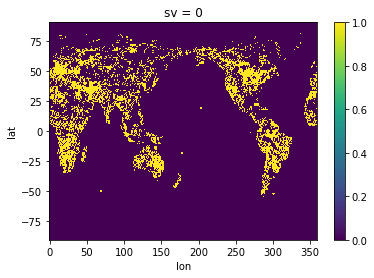

In [37]:
# This selects amplification vectors
flip_corr = 0+(GPP_corr.weighted < 0.)
flip_corr[0,:,:] = flip_corr[0,:,:].where(sv_mask.weighted.isel(sv_type=0), 0) #only reverse amplitude vectors where needed
flip_corr[1,:,:] = flip_corr[1,:,:].where(sv_mask.weighted.isel(sv_type=1), 0)
#flip_corr.isel(sv=0).plot()

# Still need a better way to think about flipping early phase vectors where needed...
max_vector = svd0.vectors.argmax(dim='time') 
min_vector = svd0.vectors.argmin(dim='time') 
flip_vector = 0+(min_vector < max_vector)
flip_vector[0,:,:] = flip_vector[0,:,:].where(sv_mask.weighted.isel(sv_type=1),0)
flip_vector[1,:,:] = flip_vector[1,:,:].where(sv_mask.weighted.isel(sv_type=0),0)

flip_combined = flip_corr + flip_vector 
flip_combined.isel(sv=0).plot()

svd2 = svd0.copy(deep=True) ## create new datasets that don't change the orig. results
for i in range(years):
    svd2.vectors[i,...] = svd2.vectors[i,...].where(flip_combined[i,...] <= 0, -1*svd2.vectors[i,...])
    svd2.weights[i,...] = svd2.weights[i,...].where(flip_combined[i,...] <= 0, -1*svd2.weights[i,...])

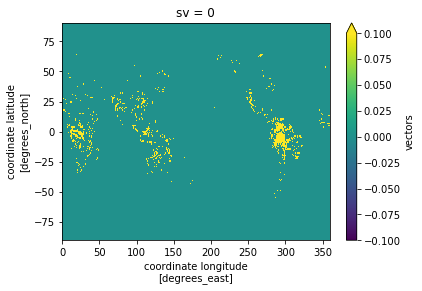

In [38]:
# add one more logical if if amplication vectors and mean vectors < 0 fip vectors & weights [maybe again...]
flip_amp =  svd2.vectors.mean(dim='time') < 0.
flip_amp[0,:,:] = flip_amp[0,:,:].where(sv_mask.weighted.isel(sv_type=0),0)
flip_amp[1,:,:] = flip_amp[1,:,:].where(sv_mask.weighted.isel(sv_type=1),0)
flip_amp.isel(sv=0).plot(robust=True)
for i in range(years):
    svd2.vectors[i,...] = svd2.vectors[i,...].where(flip_amp[i,...] <= 0, -1*svd2.vectors[i,...])
    svd2.weights[i,...] = svd2.weights[i,...].where(flip_amp[i,...] <= 0, -1*svd2.weights[i,...])

# Now repeat the correlation between vectors and climatology    
for i in range(years):
    temp_vector = svd2.vectors.isel(sv=i)
    GPP_corr.pearson[i,...] = pearson_correlation(svd0.climatology, temp_vector, 'time')
    GPP_corr.weighted[i,...] = pearson_correlation_wgt(svd0.climatology, temp_vector, GPPwgt,'time')
    GPP_corr.ranked[i,...] = spearman_correlation(svd0.climatology, temp_vector, 'time')

#GPP_corr.weighted[0,:,:].plot(robust=True);


#### This seems to work for amplitude vectors & early phase vectors in SH and NH
#### Requires reindexing time vectors for SH climatology & vectors to reflect hydrologic cycle

In [39]:
# Plot First and Second Singular Vectors
# Made this long plotting routine into a function

def monthly_plots(ds_all, ds0, ds1, a, b, multi = 0.5e4 ):
    
    fig = plt.figure(4,figsize=(6,4.5))
    barwidth = 0.2
    month = np.arange(12)
    multi = multi       #This is a totally arbitrary scale factor, decided by me, to make figures look good!
    ymax=np.max(ds0.vectors.values)

    # --- GPP, SVD 1 & 2 for regions in phase with GPP 
    vectors2plot=ds0.vectors*multi  
    mm2plot = ds_all.climatology
    ax1 = fig.add_subplot(1,2,1)

    if b > 0:
        ax1.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
    else:
        ax1.set_xticklabels(['Jul','','','Oct','','','Jan','','','Apr','',''])

    ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))-0.05,'k-',alpha=0.3,linewidth=3)
    ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))+0.35,'k-',alpha=0.3,linewidth=3)

    ax1.plot(np.array(month)+2*barwidth,vectors2plot[0,:]*0.75+0.35,'b-',linewidth=3)
    ax1.plot(np.array(month)+2*barwidth,vectors2plot[1,:]*0.75-0.05,'r-',linewidth=3)
    ax1.axhline(-0.05,color='black')
    ax1.axhline(0.35,color='black')
    ax1.set_xticks(np.array(month)+2*barwidth)
    ax1.set_yticks([-0.05,0.35])
    ax1.set_yticklabels(['SV2','SV1'])
    ax1.set_ylim([-0.2,0.65])

    ax1.text(0.5,.55,str(int(ds0.varfrac[0]*100))+"%\n$\Theta$="+str('%.2f'%ds0.theta[0]))
    ax1.text(0.5,.15,str(int(ds0.varfrac[1]*100))+"%\n$\Theta$="+str('%.2f'%ds0.theta[1]))
    ax1.title.set_text(var[0]+" "+str(a)+"-"+str(b)+", amplification")
    ax1.text(4,-0.29,'Month')

    # ----- Make second panel, where SV1 = phase shift ----
    vectors2plot=ds1.vectors*multi  
    ax2 = fig.add_subplot(1,2,2)

    if b > 0:
        ax2.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
    else:
        ax2.set_xticklabels(['Jul','','','Oct','','','Jan','','','Apr','',''])

    ax2.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))-0.05,'k-',alpha=0.3,linewidth=3)
    ax2.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))+0.35,'k-',alpha=0.3,linewidth=3)

    ax2.plot(np.array(month)+2*barwidth,vectors2plot[0,:]*0.75+0.35,'b-',linewidth=3)
    ax2.plot(np.array(month)+2*barwidth,vectors2plot[1,:]*0.75-0.05,'r-',linewidth=3)
    ax2.axhline(-0.05,color='black')
    ax2.axhline(0.35,color='black')
    ax2.set_xticks(np.array(month)+2*barwidth)
    ax2.set_yticks([-0.05,0.35])
    ax2.set_yticklabels(['SV2','SV1'])
    ax2.set_ylim([-0.2,0.65])

    ax2.text(0.5,.55,str(int(mean_svd_plotB.varfrac[0]*100))+"%\n$\Theta$="+str('%.2f'%mean_svd_plotB.theta[0]))
    ax2.text(0.5,.15,str(int(mean_svd_plotB.varfrac[1]*100))+"%\n$\Theta$="+str('%.2f'%mean_svd_plotB.theta[1]))
    ax2.title.set_text(var[0]+" "+str(a)+"-"+str(b)+", early phase")
    ax2.text(4,-0.29,'Month')
    
    plt.savefig(model+'_SV_'+var[0]+'_lat_'+str(a)+'-'+str(b)+'.eps') ;
    ax1.remove()
    ax2.remove()
    #figout = plt.tight_layout();
    #return figout

In [40]:
# calculate mean annual cycle and mean SV1 and SV2 for different regions
# TODO, JH, How do I save plots for each lat band invidually?

a = [-30,0,30,55]  # Min lat, -20 to 10 for Amazon
b = [0,30,55,80]   # Max lat
c = 0   # min lon, 280-310 for the Amazon
d = 360 # max lon 

for i in range(len(a)):
    svd_plot = svd2
    mean_svd_plot = svd_plot.sel(lat=slice(a[i],b[i]), lon=slice(c,d)).mean(('lat','lon')) 
    # -- Amplitude vector --
    mean_svd_plotA = svd_plot.where(sv_mask.weighted.isel(sv_type=0)).sel(lat=slice(a[i],b[i]), lon=slice(c,d)).mean(('lat','lon')) 
    # -- Phase shift vector -- 
    mean_svd_plotB = svd_plot.where(sv_mask.weighted.isel(sv_type=1)).sel(lat=slice(a[i],b[i]), lon=slice(c,d)).mean(('lat','lon')) 
    monthly_plots(mean_svd_plot,mean_svd_plotA,mean_svd_plotB, a=a[i], b=b[i])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

<Figure size 432x324 with 0 Axes>

### Seems to:
* Appropriately identify SV1 as amplification or early phase vectors
* SV1 explians most of varriation (at least for high & mid latitudes)
* SV2 of phase shift = amplificaiton!
* maybe additional work needed for tropics?

# ----- Correlate SV weights w/ seasonal anomalies -----
* Claculate seasonal means of detrended data
* Reshape anomaly vectors to season x year array
* Correlate GPP SV1 weights w/ seasonal GPP anomalies & 
* Reverse / flip weights where needed
* Calculate correlation for GPP SV1 weights w/ seaonal climate anomalies

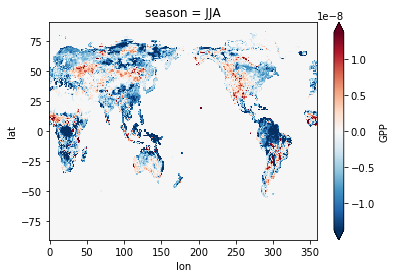

In [41]:
def dtrend(anom, dim):
    # note: apply always moves core dimensions to the end
    return xr.apply_ufunc(signal.detrend, anom,
                       input_core_dims=[[dim]],
                       output_core_dims=[[dim]],
                       kwargs={'axis': -1})


# Build datastet to hold results
dims = dict(zip(ds_anom.get('GPP').dims, ds_anom.get('GPP').shape))
out_shape = (dims['lat'], dims['lon'], 4, years)
seasonID = xr.DataArray([12,3,6,9], dims='season') # seasonal time slices
seasonName = xr.DataArray(['DJF','MAM','JJA','SON'], dims='season') # can coords be a string?
yearID   = xr.DataArray(np.unique(ds_anom.time['time.year']), dims='year')
dt_anom  = xr.Dataset( coords={"lat": ds_anom.lat, "lon": ds_anom.lon, 
                               "season": seasonName, "year": yearID} )

for v in range(len(var)):
    dt_anom[var[v]] = xr.DataArray(np.zeros(out_shape), dims=('lat', 'lon','season','year'))
    

    dt = dtrend(ds_anom.get(var[v]).load().fillna(0), 'time')
    dt_season = dt.resample(time="QS-DEC").mean().isel(time=slice(0,-1))

    # now reshape
    for m in range(len(seasonID)):
        temp = dt_season.where(dt_season.time['time.month']==seasonID[m], drop=True)
        dt_anom[var[v]][:,:,m,:] = temp


dt_anom = dt_anom.transpose('season','year','lat','lon')
dt_anom.GPP.isel(season=2).mean(dim='year').plot(robust=True);

<xarray.Dataset>
Dimensions:      (time: 12, year: 25)
Coordinates:
  * time         (time) int64 0 1 2 3 4 5 6 7 8 9 10 11
    lat          float64 -5.183
    lon          float64 300.0
    sv           int64 0
Dimensions without coordinates: year
Data variables:
    theta        float64 0.449
    varfrac      float64 0.3899
    vectors      (time) float64 2.489e-07 1.104e-06 ... -3.742e-07 -2.33e-06
    weights      (year) float64 -0.03521 -0.3351 -0.06865 ... -0.0626 0.2048
    climatology  (time) float32 6.1249586e-05 5.482344e-05 ... 6.868743e-05


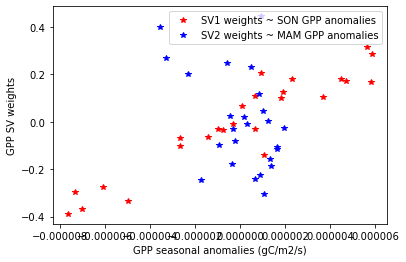

In [42]:
# Results look at example from single grid cell, with 
# GPP_sv weights ~ seasonal anomalies 
# sv1 Early shift = spring & sv2 Amplificaton = summer

tlat = -5
tlon = 300
if tlat>=0:
    plt.plot(dt_anom.GPP.sel(lat=tlat, lon=tlon, method='nearest').isel(season=1),
             svd2.weights.sel(lat=tlat, lon=tlon, method='nearest').isel(sv=0), '*', color='red')
    plt.plot(dt_anom.GPP.sel(lat=tlat, lon=tlon, method='nearest').isel(season=2),
             svd2.weights.sel(lat=tlat, lon=tlon, method='nearest').isel(sv=1), '*', color='blue')
    plt.legend(loc='upper right',labels=("SV1 weights ~ MAM GPP anomalies",
                                         "SV2 weights ~ JJA GPP anomalies"));
else:
    plt.plot(dt_anom.GPP.sel(lat=tlat, lon=tlon, method='nearest').isel(season=3),
             svd2.weights.sel(lat=tlat, lon=tlon, method='nearest').isel(sv=0), '*', color='red')
    plt.plot(dt_anom.GPP.sel(lat=tlat, lon=tlon, method='nearest').isel(season=1),
             svd2.weights.sel(lat=tlat, lon=tlon, method='nearest').isel(sv=1), '*', color='blue')
    plt.legend(loc='upper right',labels=("SV1 weights ~ SON GPP anomalies",
                                         "SV2 weights ~ MAM GPP anomalies"))

plt.xlabel(var[0]+" seasonal anomalies (gC/m2/s)")
plt.ylabel(var[0]+" SV weights");
print(svd2.sel(lat=tlat, lon=tlon, method='nearest').isel(sv=0))

#### Weights typically have have the same sign as GPP anomalies
* But not always in tropics
* Do we need to reverse vectors and weights where this negative correlation exists?
* We'll try this in a bit

### Now look for correlations for GPP sv weights & GPP anomalies
* this will be used to flip weights for sv1 as needed

In [43]:
# Write out correlation matrix for weights of GPP SV with detrended anomalies 
# Loop over each SV (2), variable (3), & season (4)

def corr_wrap(anom, svd):
    da = anom.to_array() 
    dims = dict(zip(da.dims, da.shape))
    corr_shape = (2,dims['season'], dims['lat'], dims['lon'])

    # setup output variables
    corr = xr.Dataset( coords={'sv': range(2), 'season':seasonName, 
                               "lat": ds.lat, "lon": ds.lon} )

    for v in range(len(var)):     # variables
        corr[var[v]] = xr.DataArray(np.zeros(corr_shape), dims=('sv','season','lat', 'lon'))

        # loop through to calculate correlation coef.
        for i in range(2):         # vectors
            for j in range(len(seasonName)): # seasons
                return_vals = pearson_correlation(anom.get(var[v]).isel(season=j), 
                                                  svd['weights'].isel(sv=i), 'year')
                corr[var[v]][i,j,...] = return_vals
        
    return corr

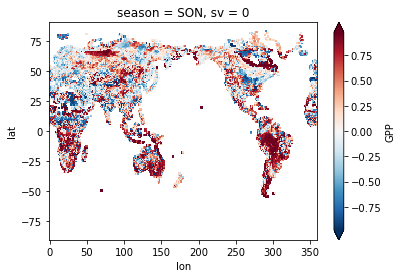

In [44]:
# Create correlation matrix
# first make year dimensions indential
svd0['year'] = dt_anom.get('year')
svd2['year'] = dt_anom.get('year')
svd0_corr = corr_wrap(dt_anom, svd0)
svd2_corr = corr_wrap(dt_anom, svd2)
svd2_corr_anom = corr_wrap(dt_anom, svd2)

# --- Check that results ar sensible ---
# GPP SV1 coorelated with JJA GPP anomalies in NH, as expected
# GPP SV1 coorelated with MAM GPP anomalies in early shift regions (NE USA + Ag.) 
svd2_corr['GPP'].isel(sv=0, season=3).plot(robust=True);

Weights do not necessarily have the same sign as GPP anomalies
(e.g. see Amazon in plots above & below)
- Itentify season with maximum abs(correlation) between SV weights & GPP anomalies
- Reverse vectors and weights where this value < 0
- repeat correlation matrix

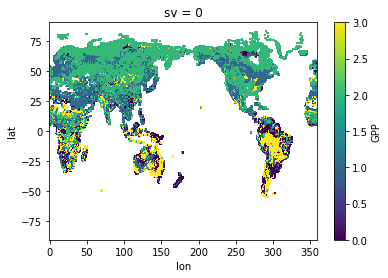

In [45]:
# xr.ufuncs.fabs calculates the absolute value for an xarray object
# argmax picks the index of the largest value across a dimension.

gppMask = svd0_corr['GPP'].max(dim='season')
maxGPP_season = xr.ufuncs.fabs(svd0_corr['GPP'].fillna(-1)).argmax(dim='season').where(gppMask.notnull())
maxGPP_season.isel(sv=0).plot(robust=True);

### Next should look at environmental correlations in dominant seasons
cor.svd[weights] ~ TBOT and TWS anomalies


In [46]:
## simplify correlations to look at values only when 
# weights from SV most strongly correlate with seasonal GPP anomalies

# 1) set up dataset to hold results
max_season_corr = xr.Dataset( coords={'sv': range(years) , "lat": ds.lat, "lon": ds.lon} )
for i in range(len(var)):
    max_season_corr[var[i]] = xr.DataArray(np.zeros(corr_shape), dims=('sv','lat', 'lon'))

# 2) loop through vectors and seasons
# write out corr coefficients where maxGPP_seaon == T
for i in range(2):         # vectors
      for j in range(len(seasonName)): # seasons
            for k in range(len(var)):
                max_season_corr.get(var[k])[i,...] = svd2_corr.get(var[k])[i,j,...].where(maxGPP_season[i,...]==j, 
                                                                                             max_season_corr.get(var[k])[i,...])
                

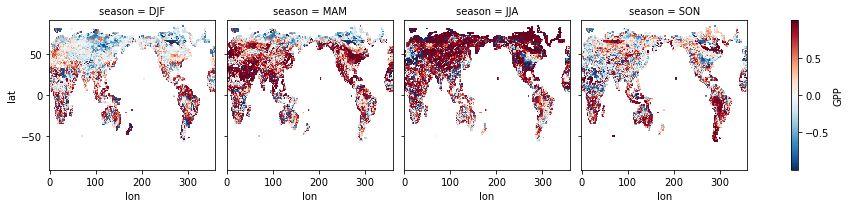

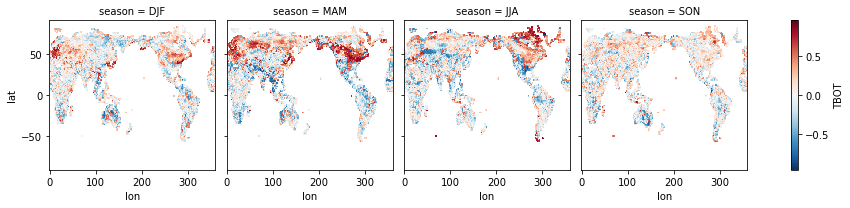

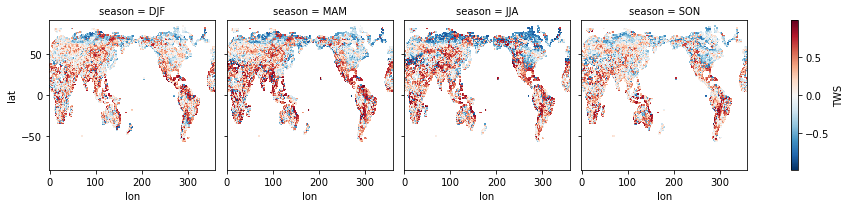

In [47]:
# use xarray facet plots for pannels
# each row show correlations between SV_1 weights and seasonal anomalies
for k in range(len(var)):
    simple = svd2_corr[var[k]].isel(sv=0).plot(x='lon', y='lat', col='season', col_wrap=4)


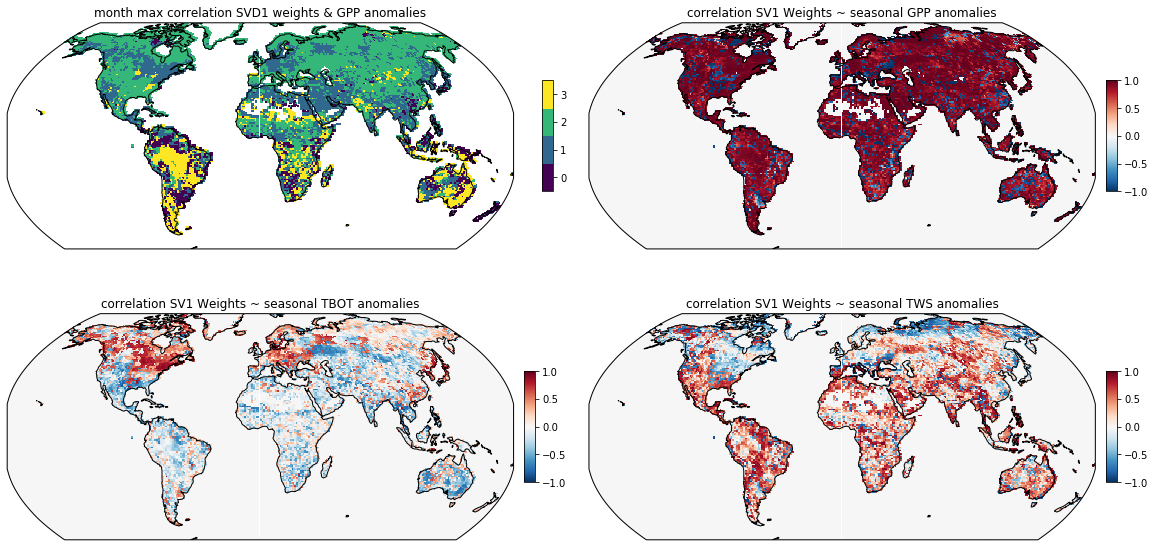

In [48]:
# -- first add season of max correlation of SV weights with GPP anomalies to dataset being plotted
max_season_corr['maxGPP_season'] = maxGPP_season
var2 = ['maxGPP_season']+var

# Now call the map_function
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,8), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))

i = 0
for index, ax in np.ndenumerate(axes):
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    da = max_season_corr[var2[i]].isel(sv=0)
    if i == 0:
        #Can I ake these arguments a list or a dictionary?
        cmap = plt.get_cmap("viridis",4)
        #cmap = colors.ListedColormap(['r', 'g', 'b', 'c'])
        vmax=3.5
        vmin=-0.5
        title='month max correlation SVD1 weights & GPP anomalies'
    else: 
        cmap='RdBu_r'
        vmax=1
        vmin=-1
        title='correlation SV1 Weights ~ seasonal '+var2[i]+' anomalies'
    map_function(da, ax=ax, title=title, cmap=cmap, vmax=vmax, vmin=vmin,cb=1)
    i = i+1


# or to provide a common color bar, set vmax/min so same values and 
#fig.colorbar(im,ax=axes.ravel().tolist(), shrink=0.5);
#fig.savefig(model+'_summary.eps')
    

### Grids characterized by early phase GPP SV1 also have higher % varriation explianted by soil water SV

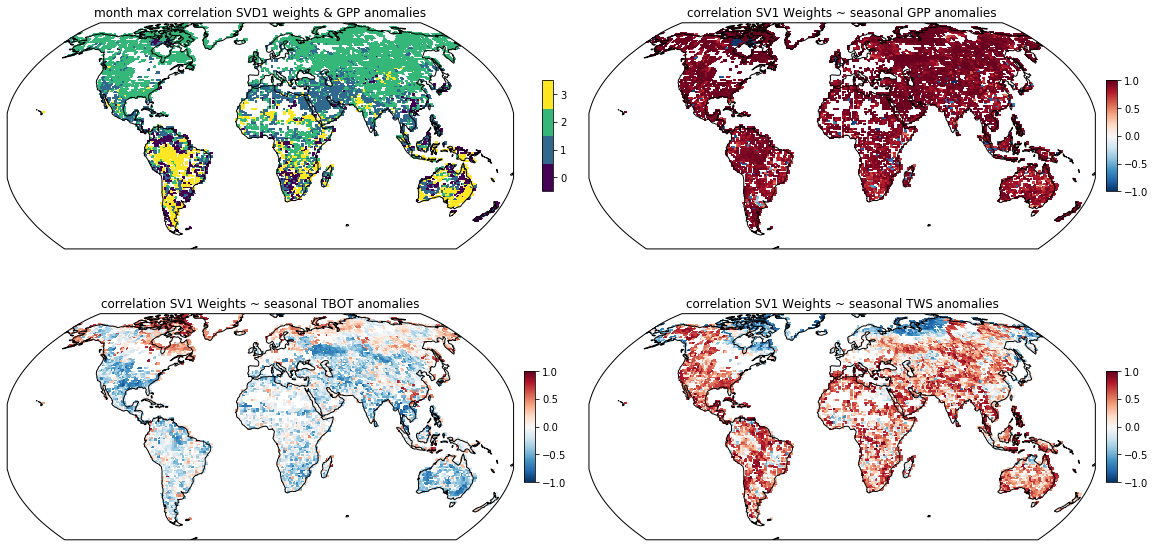

In [49]:
# Now call the map_function
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,8), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))

i = 0
for index, ax in np.ndenumerate(axes):
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    da = max_season_corr[var2[i]].isel(sv=0).where(sv_mask.weighted.isel(sv_type=0))
    if i == 0:
        #Can I ake these arguments a list or a dictionary?
        cmap = plt.get_cmap("viridis",4)
        #cmap = colors.ListedColormap(['r', 'g', 'b', 'c'])
        vmax=3.5
        vmin=-0.5
        title='month max correlation SVD1 weights & GPP anomalies'
    else: 
        cmap='RdBu_r'
        vmax=1
        vmin=-1
        title='correlation SV1 Weights ~ seasonal '+var2[i]+' anomalies'
    map_function(da, ax=ax, title=title, cmap=cmap, vmax=vmax, vmin=vmin,cb=1)
    i = i+1
    

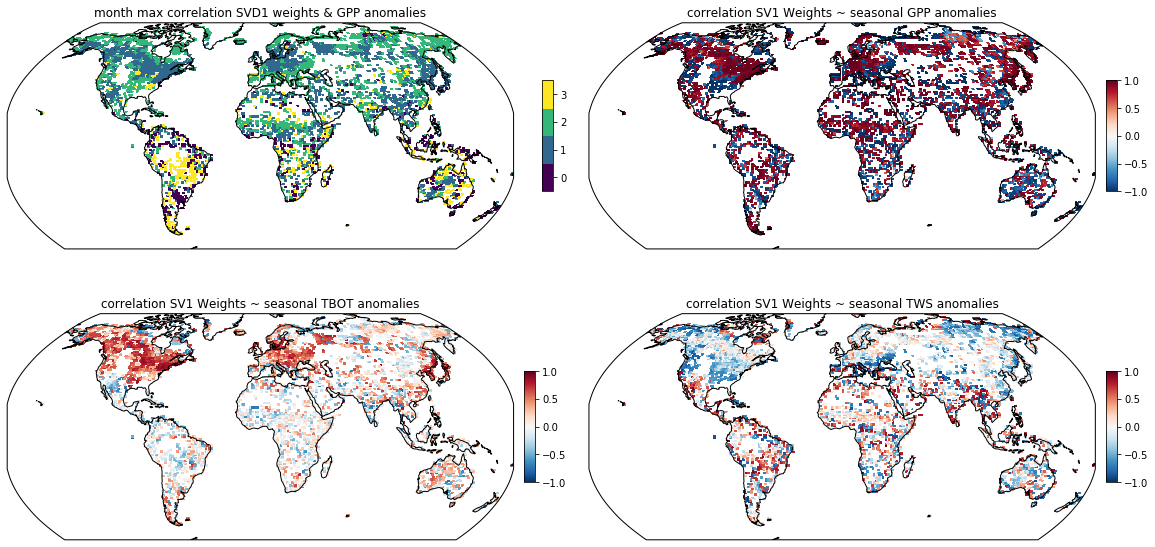

In [50]:
# Now call the map_function
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,8), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))

i = 0
for index, ax in np.ndenumerate(axes):
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    da = max_season_corr[var2[i]].isel(sv=0).where(sv_mask.weighted.isel(sv_type=1))
    if i == 0:
        #Can I ake these arguments a list or a dictionary?
        cmap = plt.get_cmap("viridis",4)
        #cmap = colors.ListedColormap(['r', 'g', 'b', 'c'])
        vmax=3.5
        vmin=-0.5
        title='month max correlation SVD1 weights & GPP anomalies'
    else: 
        cmap='RdBu_r'
        vmax=1
        vmin=-1
        title='correlation SV1 Weights ~ seasonal '+var2[i]+' anomalies'
    map_function(da, ax=ax, title=title, cmap=cmap, vmax=vmax, vmin=vmin,cb=1)
    i = i+1
    